# Modelling via scikit-learn

This notebook performs model fitting and evaluating on hold out areas, using models from scikit-learn.

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from math import sqrt
import pathlib
import os
from sklearn.externals import joblib
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
# pd.reset_option('^display')

# ignore warnings
import logging
import warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, '../utils')
import modelutils
from settings import *

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## File Locations

In [3]:
dirs = [model_dir, scaler_dir, preds_dir]
for dir_ in dirs:
    with pathlib.Path(dir_) as path:
        if not path.exists():
            path.mkdir(parents=True, exist_ok=True)

## Load Data

In [4]:
# !gsutil cp gs://immap-wash-training/training/20200826_dataset.csv {data_dir}
features = poi_features + satellite_features
raw = (pd.read_csv(data_dir + '20200826_dataset.csv')
      .query("aridity_cgiarv2 > -2e9")
      .dropna(subset = ['adm1_name'] + indicators + features))

## Fit, Predict and Evaluate Models on Holdout Areas
Trains a ridge regression and random forest model to predict each of the 3 WASH indicators, setting specified areas as test data (done one by one) and everything else as training data

### Using Both Urban and Rural Dataset

100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


perc_hh_no_water_supply
{'correlation': 0.5549407872286842, 'r2': 0.3079592773299918, 'mae': 0.16049780668506058, 'rmse': 0.24332334112036633}
perc_hh_no_toilet
{'correlation': 0.5594016839989403, 'r2': 0.31293024406085024, 'mae': 0.17902933773233987, 'rmse': 0.26111214575588265}
perc_hh_no_sewage
{'correlation': 0.5939613833150307, 'r2': 0.3527901248695048, 'mae': 0.21093958302458254, 'rmse': 0.2725894280358114}


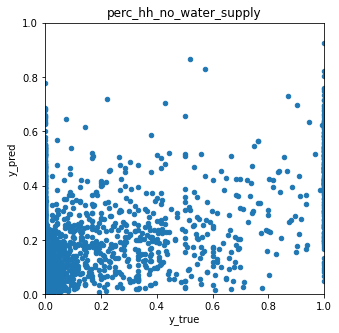

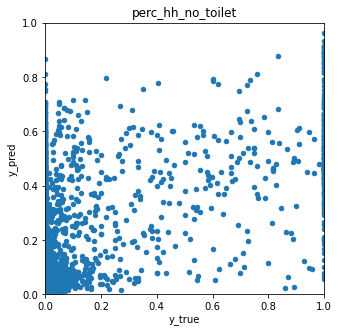

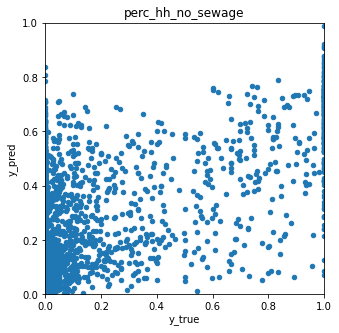

In [25]:
experiment = 'all'
df = raw.copy()
test_areas = ['bogot_dc', 'cundinamarca', 'la_guajira', 'nario']
results = modelutils.fit_models(df, features, indicators, test_areas, prefix = experiment)
modelutils.predict_on_holdout_areas(df, test_areas, features, indicators, prefix = experiment)
modelutils.evaluate_results(indicators = indicators, prefix = experiment)

### Using Urban Dataset Only

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting using the following features:
['nearest_waterway', 'nearest_commercial', 'nearest_restaurant', 'nearest_hospital', 'nearest_airport', 'nearest_highway', 'vegetation', 'aridity_cgiarv2', 'temperature', 'nighttime_lights', 'population', 'elevation', 'urban_index']
Evaluating on the following test areas:
['bogot_dc', 'norte_de_santander', 'la_guajira', 'nario']


100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


perc_hh_no_water_supply
{'correlation': 0.6558704813201296, 'r2': 0.43016608826709846, 'mae': 0.08255238282855093, 'rmse': 0.13708985872804705}
perc_hh_no_toilet
{'correlation': 0.6696840514034953, 'r2': 0.4484767287041993, 'mae': 0.04544186584691107, 'rmse': 0.09232482404321923}
perc_hh_no_sewage
{'correlation': 0.6472221395050102, 'r2': 0.41889649786544286, 'mae': 0.10633368279934848, 'rmse': 0.16980901295387263}


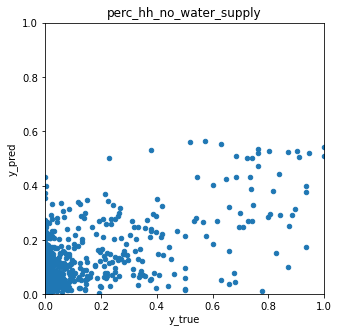

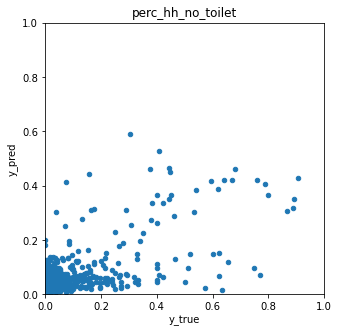

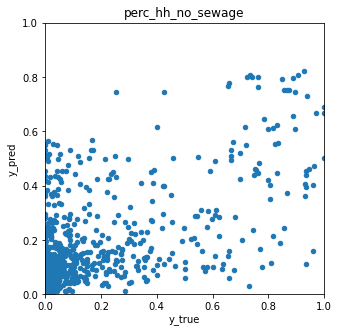

In [26]:
experiment = 'urban'
df = raw.query("urbanity == 'u'")
test_areas = ['bogot_dc', 'norte_de_santander', 'la_guajira', 'nario']
results = modelutils.fit_models(df, features, indicators, test_areas, prefix = experiment)
modelutils.predict_on_holdout_areas(df, test_areas, features, indicators, prefix = experiment)
modelutils.evaluate_results(indicators = indicators, prefix = experiment)

### Using Rural Dataset Only

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting using the following features:
['nearest_waterway', 'nearest_commercial', 'nearest_restaurant', 'nearest_hospital', 'nearest_airport', 'nearest_highway', 'vegetation', 'aridity_cgiarv2', 'temperature', 'nighttime_lights', 'population', 'elevation', 'urban_index']
Evaluating on the following test areas:
['cundinamarca', 'choc', 'la_guajira', 'nario']


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


perc_hh_no_water_supply
{'correlation': 0.6368927473313264, 'r2': 0.4056323716032448, 'mae': 0.2735497768114403, 'rmse': 0.32351862100614476}
perc_hh_no_toilet
{'correlation': 0.7924204718398132, 'r2': 0.6279302041908322, 'mae': 0.32856921055362476, 'rmse': 0.3826078892093132}
perc_hh_no_sewage
{'correlation': 0.7924204718398133, 'r2': 0.6279302041908325, 'mae': 0.3285692105536247, 'rmse': 0.38260788920931327}


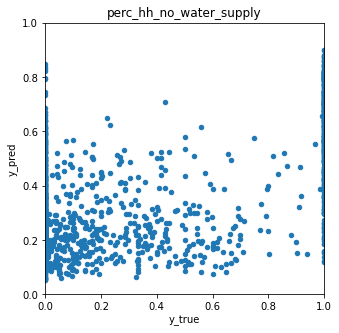

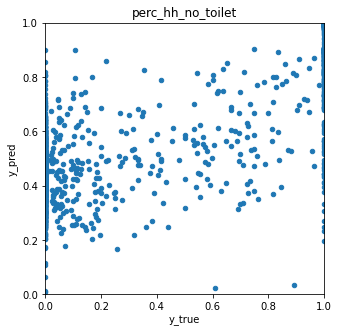

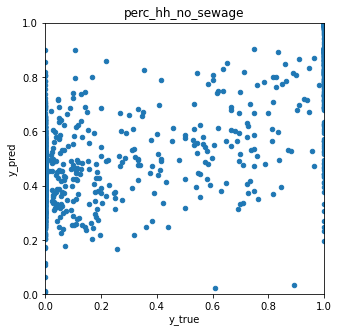

In [27]:
experiment = 'rural'
df = raw.query("urbanity == 'r'")
test_areas = ['cundinamarca', 'choc', 'la_guajira', 'nario']
results = modelutils.fit_models(df, features, indicators, test_areas, prefix = experiment)
modelutils.predict_on_holdout_areas(df, test_areas, features, indicators, prefix = experiment)
modelutils.evaluate_results(indicators = indicators, prefix = experiment)

## Check Performance by Area

In [11]:
df = pd.read_csv(data_dir + 'all_predictions.csv')
areas = list(df.adm1_name.unique())
for area in areas:
    print(area)
    sub = df.query(f"adm1_name == '{area}'")
    print(modelutils.calculate_metrics(sub['y_true'], sub['y_pred']))

bogot_dc
{'correlation': 0.3871073765404148, 'r2': 0.1498521209720025, 'mae': 0.05383042336553263, 'rmse': 0.10214335535431589}
cundinamarca
{'correlation': 0.24709127463937888, 'r2': 0.06105409800291296, 'mae': 0.19833737206073546, 'rmse': 0.2686348047047588}
nario
{'correlation': 0.8647779351307365, 'r2': 0.7478408770889804, 'mae': 0.18384475590476793, 'rmse': 0.2625833315727721}
la_guajira
{'correlation': 0.6742144297985095, 'r2': 0.45456509734852935, 'mae': 0.269864536375588, 'rmse': 0.33655498247634574}
